In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import libraries
!pip install ultralytics
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from skimage import img_as_ubyte
from skimage import io as ski
from skimage.transform import resize
from skimage import filters
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

# **Image preprocessing**

In [ ]:
#functions to load and preprocess the data
def find_index(input, id):
    for i in range(len(input)):
        if input[i] == id:
            return i
            break

def load_videos(dataset):
    iter_data = iter(dataset['train'])
    all_videos = []
    try:
        while True:
            video = next(iter_data)
            all_videos.append(video)
    except StopIteration:
        pass
    return all_videos


def process_videos(all_videos):
    images_list = []
    bboxes_list = []
    resolutions_list = []
    bbox_ids_list = []
    image_id = 0
    for train_data in all_videos:
        num_frames = int(train_data['metadata']['num_frames'])
        resolution = [int(train_data['metadata']['height'].numpy()), int(train_data['metadata']['width'].numpy())]
        for i in range(num_frames):
            image = train_data['video'][i, :, :, :].numpy()
            images_list.append(image)
            resolutions_list.append(resolution)
            frame_bboxes = []
            for id in range(train_data['instances']['bbox_frames'].shape[0]):
                if i in train_data['instances']['bbox_frames'][id]:
                    t = find_index(train_data['instances']['bbox_frames'][id], i)
                    item = train_data['instances']['bboxes'][id, t, :]
                    y_min = int(item[0] * float(resolution[0]))
                    x_min = int(item[1] * float(resolution[1]))
                    y_max = int(item[2] * float(resolution[0]))
                    x_max = int(item[3] * float(resolution[1]))
                    y_min_normalized = y_min / float(resolution[0])
                    x_min_normalized = x_min / float(resolution[1])
                    y_max_normalized = y_max / float(resolution[0])
                    x_max_normalized = x_max / float(resolution[1])
                    category = train_data['instances']['category'][id].numpy()
                    frame_bboxes.append([category, x_min_normalized, y_min_normalized, x_max_normalized, y_max_normalized])
            bboxes_list.append(frame_bboxes)
    df = pd.DataFrame({
        'image': images_list,
        'resolution': resolutions_list,
        'bounding_boxes': bboxes_list
    })
    return df

def process_all_videos(video_datasets):
    dfs = []
    for video_data in video_datasets:
        df = process_videos(video_data)
        dfs.append(df)
    final_df = pd.concat(dfs, ignore_index=True)
    return final_df


#functions to download the data as yolo_dataset
def create_folder(folder_name, location):
  '''
  Function to create a folder with desired name in the desired location
  folder_name: Given to the fxn as a string with desired name
  location: given to the fxn as a string with the desired location
  '''
  folder = os.path.join(location, folder_name)
  if not os.path.exists(folder):
    os.makedirs(folder)
    print(f"Created the folder:{folder_name}", f"in {location}")
  else:
    print(f"Folder already EXISTS!!!")
  return

def create_yolo_data_dir(dataset_folder_name, location):
  '''
  This function takes the name of the main dataset folder and the location,
  then creates the configuration below that yolo needs for training.
  It uses the "create Folder" function defined above.
  Yolo_dataset
  |
  |___Train
      |__images
      |__labels
  |
  |___val
      |__images
      |__labels
  |
  |___test
      |__images
      |__labels
  '''
  sub_dir = ['train', 'val', 'test']
  sub_dir_split = ['images', 'labels']
  for dir in sub_dir:
    create_folder(dir, dataset_folder_name)
    for dir_ in sub_dir_split:
      create_folder(dir_, location + "/" + dataset_folder_name +'/' + dir)
  return

def save_data(df, images_subpath, labels_subpath, data_type):
    for index, row in df.iterrows():
        image_uint8 = img_as_ubyte(row['image'])
        img_filename = f"{data_type}_{index}.png"
        img_path = os.path.join(images_subpath, img_filename)
        ski.imsave(img_path, image_uint8)
        label_filename = f"{data_type}_{index}.txt"
        label_path = os.path.join(labels_subpath, label_filename)
        with open(label_path, 'w') as f:
            for bbox in row['shoes']:
                x_center = (bbox[1] + bbox[3]) / 2
                y_center = (bbox[2] + bbox[4]) / 2
                width = bbox[3] - bbox[1]
                height = bbox[4] - bbox[2]
                f.write(f"0 {x_center} {y_center} {width} {height}\n")

In [ ]:
#load the data
PROJECT_ROOT_DIR = '/content/drive/MyDrive/cv_course/tensorflow_data/elg7186_projectdata/'
data_path = os.path.join(PROJECT_ROOT_DIR)
os.makedirs(data_path, exist_ok = True)

linear_data_set = tfds.load('linear_movement_rotate',data_dir=data_path)
rotate_data_set = tfds.load('rotation_rotate',data_dir=data_path)
fixed_data_set = tfds.load('fixed_random_rotate', data_dir=data_path)

In [ ]:
#preprocess all three videos
first_video = [load_videos(fixed_data_set)]
second_video = [load_videos(linear_data_set)]
third_video = [load_videos(rotate_data_set)]

first_df = process_all_videos(first_video)
second_df = process_all_videos(second_video)
third_df = process_all_videos(third_video)

final_df=pd.concat([first_df, second_df, third_df], ignore_index=True)
final_df

image  resolution  \
0     [[[238, 200, 175], [235, 199, 171], [234, 199,...  [256, 256]   
1     [[[238, 200, 175], [235, 199, 171], [234, 199,...  [256, 256]   
2     [[[238, 200, 175], [235, 199, 171], [234, 199,...  [256, 256]   
3     [[[238, 200, 175], [235, 199, 171], [234, 199,...  [256, 256]   
4     [[[238, 200, 175], [235, 199, 171], [234, 199,...  [256, 256]   
...                                                 ...         ...   
2155  [[[180, 75, 46], [174, 73, 47], [165, 68, 43],...  [256, 256]   
2156  [[[194, 87, 54], [193, 86, 54], [193, 84, 53],...  [256, 256]   
2157  [[[194, 89, 51], [194, 89, 51], [194, 89, 51],...  [256, 256]   
2158  [[[188, 84, 49], [188, 85, 49], [191, 87, 51],...  [256, 256]   
2159  [[[193, 88, 53], [191, 87, 51], [192, 88, 52],...  [256, 256]   

                                         bounding_boxes  
0     [[13, 0.40234375, 0.2890625, 0.6953125, 0.5039...  
1     [[13, 0.40625, 0.296875, 0.6953125, 0.5], [6, ...  
2     [[13, 0.40625, 0.30078125, 0.69921875, 0.50390...  
3     [[13, 0.40625, 0.30859375, 0.703125, 0.5039062...  
4     [[13, 0.40234375, 0.32421875, 0.7109375, 0.503...  
...                                                 ...  
2155  [[6, 0.33984375, 0.34375, 0.5703125, 0.5742187...  
2156  [[6, 0.3671875, 0.34375, 0.5546875, 0.5703125]...  
2157  [[6, 0.3984375, 0.34765625, 0.53515625, 0.5625...  
2158  [[6, 0.40234375, 0.34375, 0.55859375, 0.5625],...  
2159  [[6, 0.38671875, 0.3359375, 0.5859375, 0.5625]...  

[2160 rows x 3 columns]

In [ ]:
# Getting the dataframe of class 14: shoe
df_shoes = final_df
df_shoes['shoes'] = df_shoes['bounding_boxes'].apply(lambda bboxes: [bbox for bbox in bboxes if bbox[0] == 14])
df_shoes = df_shoes[df_shoes['shoes'].map(len)>0]
df_shoes

image  resolution  \
0     [[[238, 200, 175], [235, 199, 171], [234, 199,...  [256, 256]   
1     [[[238, 200, 175], [235, 199, 171], [234, 199,...  [256, 256]   
2     [[[238, 200, 175], [235, 199, 171], [234, 199,...  [256, 256]   
3     [[[238, 200, 175], [235, 199, 171], [234, 199,...  [256, 256]   
4     [[[238, 200, 175], [235, 199, 171], [234, 199,...  [256, 256]   
...                                                 ...         ...   
2131  [[[19, 19, 23], [23, 23, 27], [25, 25, 29], [2...  [256, 256]   
2132  [[[36, 36, 39], [39, 41, 45], [35, 36, 42], [3...  [256, 256]   
2133  [[[76, 66, 63], [93, 82, 72], [100, 92, 89], [...  [256, 256]   
2134  [[[90, 99, 81], [84, 88, 62], [93, 100, 83], [...  [256, 256]   
2135  [[[74, 101, 78], [100, 119, 99], [97, 121, 110...  [256, 256]   

                                         bounding_boxes  \
0     [[13, 0.40234375, 0.2890625, 0.6953125, 0.5039...   
1     [[13, 0.40625, 0.296875, 0.6953125, 0.5], [6, ...   
2     [[13, 0.40625, 0.30078125, 0.69921875, 0.50390...   
3     [[13, 0.40625, 0.30859375, 0.703125, 0.5039062...   
4     [[13, 0.40234375, 0.32421875, 0.7109375, 0.503...   
...                                                 ...   
2131  [[16, 0.40234375, 0.4609375, 0.7734375, 0.8203...   
2132  [[16, 0.3359375, 0.47265625, 0.734375, 0.85546...   
2133  [[16, 0.265625, 0.484375, 0.68359375, 0.882812...   
2134  [[16, 0.19140625, 0.49609375, 0.62890625, 0.90...   
2135  [[16, 0.11328125, 0.50390625, 0.578125, 0.9257...   

                                                  shoes  
0     [[14, 0.41796875, 0.4609375, 0.453125, 0.49609...  
1      [[14, 0.4375, 0.4609375, 0.4765625, 0.49609375]]  
2     [[14, 0.4453125, 0.4609375, 0.484375, 0.496093...  
3     [[14, 0.4453125, 0.45703125, 0.48828125, 0.496...  
4     [[14, 0.44140625, 0.453125, 0.48828125, 0.4960...  
...                                                 ...  
2131  [[14, 0.30859375, 0.4609375, 0.48828125, 0.566...  
2132  [[14, 0.296875, 0.4609375, 0.48046875, 0.55859...  
2133  [[14, 0.28125, 0.4609375, 0.47265625, 0.558593...  
2134  [[14, 0.26953125, 0.4609375, 0.46484375, 0.550...  
2135  [[14, 0.2578125, 0.45703125, 0.45703125, 0.546...  

[1094 rows x 4 columns]

In [ ]:
#splitting the dataframe "df_shoes" to train and validation and test:
df_shoes_train, temp = train_test_split(df_shoes, test_size=0.3, random_state=42)
df_shoes_val, df_shoes_test = train_test_split(temp, test_size=0.5, random_state=42)

In [ ]:
#Using the defined function above to create the Yolo_dataset folders configuration
create_yolo_data_dir("Yolo_dataset","/content/drive/MyDrive/cv_course" )

# Saving images and labels in their specified folders
save_data(df_shoes_train,"/content/drive/MyDrive/cv_course/Yolo_dataset/train/images", "/content/drive/MyDrive/cv_course/Yolo_dataset/train/labels", "train" )
save_data(df_shoes_val, "/content/drive/MyDrive/cv_course/Yolo_dataset/val/images", "/content/drive/MyDrive/cv_course/Yolo_dataset/val/labels", "val")
save_data(df_shoes_test, "/content/drive/MyDrive/cv_course/Yolo_dataset/test/images", "/content/drive/MyDrive/cv_course/Yolo_dataset/test/labels", "test")

Created the folder:train in Yolo_dataset
Created the folder:images in /content/drive/MyDrive/cv_course/Yolo_dataset/train
Created the folder:labels in /content/drive/MyDrive/cv_course/Yolo_dataset/train
Created the folder:val in Yolo_dataset
Created the folder:images in /content/drive/MyDrive/cv_course/Yolo_dataset/val
Created the folder:labels in /content/drive/MyDrive/cv_course/Yolo_dataset/val
Created the folder:test in Yolo_dataset
Created the folder:images in /content/drive/MyDrive/cv_course/Yolo_dataset/test
Created the folder:labels in /content/drive/MyDrive/cv_course/Yolo_dataset/test


# **Training and testing**

In [ ]:
#train the model
yolo_main = YOLO("yolov8n.yaml")
yolo_main.train(data="/content/drive/MyDrive/cv_course/data_yolo.yaml", epochs = 100)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 63.3MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n summary: 225 layers, 3011043 parameters, 3011027 gradients, 8.2 GFLOPs

TensorBoard: Start with 'tensorboard --logdir runs/detect/train', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 54.6MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/cv_course/Yolo_dataset/train/labels... 765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 765/765 [00:01<00:00, 455.84it/s]


train: New cache created: /content/drive/MyDrive/cv_course/Yolo_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/cv_course/Yolo_dataset/val/labels... 164 images, 0 backgrounds, 0 corrupt: 100%|██████████| 164/164 [00:00<00:00, 340.60it/s]


val: New cache created: /content/drive/MyDrive/cv_course/Yolo_dataset/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.57G       3.63      4.149       4.19         51        640: 100%|██████████| 48/48 [00:09<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


                   all        164        324   0.000528     0.0802    0.00459   0.000894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.55G      3.273      3.535      3.546         35        640: 100%|██████████| 48/48 [00:06<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]

                   all        164        324   0.000726     0.0463   0.000383    0.00012



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.57G      3.047      3.202      3.122         49        640: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]

                   all        164        324      0.104     0.0957     0.0329     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.57G      2.782      3.018      2.932         43        640: 100%|██████████| 48/48 [00:06<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]

                   all        164        324      0.103      0.204     0.0623      0.021



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.57G      2.558       2.79      2.754         45        640: 100%|██████████| 48/48 [00:06<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.47it/s]

                   all        164        324      0.205      0.198      0.106     0.0375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.56G      2.395      2.607      2.573         38        640: 100%|██████████| 48/48 [00:06<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]

                   all        164        324      0.258      0.302      0.181     0.0751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.57G      2.236      2.469      2.456         40        640: 100%|██████████| 48/48 [00:06<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]

                   all        164        324      0.311      0.287      0.212     0.0962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.55G      2.135      2.358      2.365         28        640: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]

                   all        164        324      0.429      0.309      0.313      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.57G      2.023      2.238      2.261         35        640: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]

                   all        164        324      0.333      0.345      0.256      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.59G      1.926      2.094      2.161         39        640: 100%|██████████| 48/48 [00:06<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]

                   all        164        324      0.542      0.423       0.42      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.57G      1.877      1.996      2.109         36        640: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]

                   all        164        324      0.551      0.406      0.468      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.59G      1.777      1.927      2.027         38        640: 100%|██████████| 48/48 [00:06<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.50it/s]

                   all        164        324      0.556      0.481      0.485      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.57G      1.686       1.86      1.958         51        640: 100%|██████████| 48/48 [00:06<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]

                   all        164        324       0.54      0.522      0.546      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.57G      1.643      1.782      1.923         45        640: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]

                   all        164        324      0.605      0.524      0.548      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.57G      1.607      1.761      1.873         39        640: 100%|██████████| 48/48 [00:06<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]

                   all        164        324      0.545      0.562      0.539      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.57G       1.57      1.708      1.837         51        640: 100%|██████████| 48/48 [00:06<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.50it/s]

                   all        164        324      0.653      0.546      0.605      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.59G      1.571      1.675      1.836         41        640: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]

                   all        164        324      0.558      0.481      0.484      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.57G      1.488      1.632      1.774         44        640: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.55it/s]

                   all        164        324      0.704      0.586      0.646      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.57G      1.422       1.56      1.714         42        640: 100%|██████████| 48/48 [00:06<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]

                   all        164        324      0.658      0.636      0.666      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.57G       1.42      1.514      1.708         39        640: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.47it/s]

                   all        164        324      0.705      0.672        0.7      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.57G      1.386      1.458      1.688         39        640: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]

                   all        164        324      0.684      0.707      0.712      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.57G      1.374      1.441      1.663         28        640: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.58it/s]

                   all        164        324      0.717      0.719      0.754      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.57G      1.354       1.41      1.643         32        640: 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]

                   all        164        324      0.719      0.633      0.686      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.57G      1.274      1.359      1.583         48        640: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]

                   all        164        324      0.776      0.673      0.746      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.57G      1.283      1.357      1.588         33        640: 100%|██████████| 48/48 [00:06<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.12it/s]

                   all        164        324      0.704      0.716      0.761      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.57G      1.286      1.356      1.576         38        640: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]

                   all        164        324      0.776      0.756      0.806      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.55G      1.258      1.314      1.562         44        640: 100%|██████████| 48/48 [00:06<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]

                   all        164        324      0.782      0.731      0.776      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.57G      1.241      1.283      1.555         40        640: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]

                   all        164        324      0.789      0.752      0.781      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.56G      1.222       1.25      1.536         35        640: 100%|██████████| 48/48 [00:06<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]

                   all        164        324      0.849      0.716      0.802      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.57G      1.205      1.232      1.508         48        640: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]

                   all        164        324      0.791      0.701      0.806      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.55G      1.197      1.223      1.497         33        640: 100%|██████████| 48/48 [00:07<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]

                   all        164        324      0.814      0.744      0.809      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.57G      1.177      1.165      1.487         45        640: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]

                   all        164        324      0.766      0.738      0.811      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.56G       1.14      1.164      1.462         37        640: 100%|██████████| 48/48 [00:06<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]

                   all        164        324      0.737       0.79      0.819      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.57G      1.113      1.143      1.437         30        640: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.10it/s]

                   all        164        324       0.85      0.799      0.861      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.59G      1.202      1.173      1.508         43        640: 100%|██████████| 48/48 [00:06<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.55it/s]

                   all        164        324      0.797      0.787      0.858      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.59G       1.13      1.117      1.452         36        640: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]

                   all        164        324       0.83      0.725      0.824      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.57G      1.149      1.112      1.463         40        640: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.61it/s]

                   all        164        324      0.828       0.73      0.837      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.56G      1.125      1.101      1.427         38        640: 100%|██████████| 48/48 [00:06<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]

                   all        164        324      0.826      0.793      0.855      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.57G       1.08      1.059      1.407         37        640: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]

                   all        164        324      0.826      0.778      0.846      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.55G      1.106      1.072      1.437         38        640: 100%|██████████| 48/48 [00:06<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]

                   all        164        324      0.864      0.815      0.882      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.55G      1.094      1.047      1.419         43        640: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]

                   all        164        324      0.822      0.841      0.871      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.55G      1.047          1      1.384         37        640: 100%|██████████| 48/48 [00:07<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]

                   all        164        324      0.841      0.809      0.887      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.55G      1.056     0.9759      1.392         42        640: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]

                   all        164        324      0.818      0.775      0.852      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.56G      1.039     0.9563      1.387         48        640: 100%|██████████| 48/48 [00:06<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.55it/s]

                   all        164        324      0.869      0.812        0.9      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.57G      1.044     0.9501      1.362         27        640: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.57it/s]

                   all        164        324       0.92      0.785      0.894      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.57G       1.01     0.9323      1.353         34        640: 100%|██████████| 48/48 [00:06<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]

                   all        164        324      0.883      0.814      0.894      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.57G      1.023     0.9484       1.37         38        640: 100%|██████████| 48/48 [00:06<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]

                   all        164        324      0.854      0.769      0.856      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.55G      1.001     0.9239      1.351         29        640: 100%|██████████| 48/48 [00:06<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.55it/s]

                   all        164        324      0.887      0.826      0.904       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.55G      1.001     0.9117       1.35         43        640: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]

                   all        164        324      0.921      0.787      0.886      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.55G     0.9763     0.9105      1.338         43        640: 100%|██████████| 48/48 [00:07<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.56it/s]

                   all        164        324       0.92      0.821      0.914      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.57G     0.9703     0.8659      1.327         45        640: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]

                   all        164        324      0.872      0.846      0.898      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.57G      0.985     0.8929      1.334         46        640: 100%|██████████| 48/48 [00:06<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.50it/s]

                   all        164        324      0.901       0.81      0.907      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.55G     0.9581     0.8489      1.326         41        640: 100%|██████████| 48/48 [00:06<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]

                   all        164        324      0.895      0.809      0.911      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.55G     0.9531     0.8669      1.298         32        640: 100%|██████████| 48/48 [00:06<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.60it/s]

                   all        164        324      0.886      0.841      0.919      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.55G     0.9475     0.8548      1.307         48        640: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.12it/s]

                   all        164        324        0.9      0.843      0.912      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.57G     0.9192     0.8652      1.291         39        640: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]

                   all        164        324      0.927      0.857      0.924      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.57G     0.9196     0.8048      1.286         53        640: 100%|██████████| 48/48 [00:06<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]

                   all        164        324      0.912      0.843      0.923      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.55G     0.9163     0.8376       1.28         44        640: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.58it/s]

                   all        164        324      0.951       0.84      0.926      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.55G      0.919     0.8133      1.283         38        640: 100%|██████████| 48/48 [00:07<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]

                   all        164        324        0.9      0.864      0.926      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.56G     0.9367     0.8228      1.293         40        640: 100%|██████████| 48/48 [00:06<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]

                   all        164        324      0.923      0.853      0.927      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.56G      0.896     0.7904       1.26         25        640: 100%|██████████| 48/48 [00:07<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]

                   all        164        324      0.892       0.87       0.93      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.56G      0.914     0.7722      1.274         47        640: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]

                   all        164        324      0.945      0.852       0.93      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.57G     0.8909     0.7804      1.263         34        640: 100%|██████████| 48/48 [00:06<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]

                   all        164        324      0.922      0.838      0.925      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.55G     0.9026     0.7891      1.279         33        640: 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]

                   all        164        324      0.911      0.852      0.931      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.57G     0.8818     0.7508      1.248         32        640: 100%|██████████| 48/48 [00:06<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.57it/s]

                   all        164        324      0.937      0.867      0.938       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.55G     0.8862      0.754      1.245         33        640: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]

                   all        164        324      0.959       0.88       0.94      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.57G     0.8629     0.7275      1.226         45        640: 100%|██████████| 48/48 [00:06<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]

                   all        164        324      0.949       0.86      0.937      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.56G     0.8751      0.734      1.251         36        640: 100%|██████████| 48/48 [00:06<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]

                   all        164        324      0.949      0.886      0.942      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.55G     0.8703     0.7449      1.243         33        640: 100%|██████████| 48/48 [00:06<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.63it/s]

                   all        164        324      0.972       0.87      0.943      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.55G     0.8455      0.714      1.222         34        640: 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.03it/s]

                   all        164        324      0.979      0.852      0.945      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.57G     0.8612     0.7327      1.244         43        640: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.72it/s]

                   all        164        324      0.938      0.843      0.926      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.55G     0.8792     0.7338      1.258         32        640: 100%|██████████| 48/48 [00:06<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]

                   all        164        324      0.941      0.928      0.959      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.56G     0.8157     0.6877      1.209         35        640: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]

                   all        164        324      0.951      0.897      0.949      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.55G     0.8392     0.7032      1.223         25        640: 100%|██████████| 48/48 [00:06<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]

                   all        164        324      0.968       0.87      0.949      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.55G     0.8109     0.6748      1.194         26        640: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]

                   all        164        324      0.949      0.916      0.957      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.55G     0.8518     0.6981      1.232         35        640: 100%|██████████| 48/48 [00:07<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]

                   all        164        324       0.95      0.898      0.954      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.57G     0.8334     0.6932      1.228         31        640: 100%|██████████| 48/48 [00:06<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]

                   all        164        324      0.969      0.872      0.957      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.56G     0.8485     0.6924      1.218         39        640: 100%|██████████| 48/48 [00:06<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]

                   all        164        324      0.944      0.892      0.956      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.56G     0.8387     0.6831      1.219         38        640: 100%|██████████| 48/48 [00:06<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]

                   all        164        324      0.968      0.895      0.955      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.55G     0.8228     0.6692      1.201         38        640: 100%|██████████| 48/48 [00:07<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]

                   all        164        324      0.957      0.901      0.957      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.55G     0.8156     0.6554      1.202         38        640: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]

                   all        164        324      0.963      0.886      0.957      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.57G     0.8026     0.6612      1.191         23        640: 100%|██████████| 48/48 [00:07<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.56it/s]

                   all        164        324      0.951      0.899      0.955      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.59G     0.7882     0.6212      1.185         39        640: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]

                   all        164        324      0.972      0.904      0.962      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.57G     0.7856     0.6398      1.179         42        640: 100%|██████████| 48/48 [00:06<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]

                   all        164        324      0.954      0.895      0.953       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.57G     0.7852     0.6428      1.184         30        640: 100%|██████████| 48/48 [00:06<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]

                   all        164        324      0.964      0.912      0.961      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.55G     0.7683     0.6182      1.158         43        640: 100%|██████████| 48/48 [00:06<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.56it/s]

                   all        164        324      0.973      0.914      0.961      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.55G     0.7794     0.6375      1.182         44        640: 100%|██████████| 48/48 [00:06<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]

                   all        164        324      0.958      0.924      0.961      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.57G     0.7675     0.6192      1.161         43        640: 100%|██████████| 48/48 [00:06<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.80it/s]

                   all        164        324      0.987      0.904       0.96       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.59G     0.7879     0.6301      1.192         47        640: 100%|██████████| 48/48 [00:06<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.05it/s]

                   all        164        324       0.98      0.898      0.955      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.57G     0.7722     0.6313      1.177         34        640: 100%|██████████| 48/48 [00:06<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]

                   all        164        324      0.965      0.927      0.966      0.833


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.55G     0.6415     0.5122      1.083         20        640: 100%|██████████| 48/48 [00:08<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]

                   all        164        324      0.942      0.914      0.955      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.55G     0.6166     0.4751      1.067         20        640: 100%|██████████| 48/48 [00:06<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]

                   all        164        324      0.958      0.921       0.96      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.55G     0.6275     0.4752       1.08         24        640: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.57it/s]

                   all        164        324      0.977      0.917      0.965      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.55G     0.6031     0.4489      1.058         21        640: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]

                   all        164        324      0.987      0.901      0.959      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.55G     0.6109     0.4715      1.068         19        640: 100%|██████████| 48/48 [00:06<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]

                   all        164        324       0.97      0.905      0.962      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.55G     0.6089     0.4685      1.063         28        640: 100%|██████████| 48/48 [00:06<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]

                   all        164        324       0.98        0.9      0.963      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.55G     0.5958     0.4519       1.05         22        640: 100%|██████████| 48/48 [00:06<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]

                   all        164        324      0.968      0.926      0.968      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.55G     0.5929     0.4494      1.048         27        640: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]

                   all        164        324       0.98      0.913      0.967      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.55G     0.5915     0.4439       1.05         27        640: 100%|██████████| 48/48 [00:06<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.69it/s]

                   all        164        324      0.978       0.92      0.968       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.55G     0.5906     0.4371      1.044         26        640: 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]

                   all        164        324      0.974      0.923      0.964      0.851



100 epochs completed in 0.239 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


                   all        164        324      0.974      0.923      0.964      0.851
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 11.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x782b0d3cb580>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
#results of the last 5 epochs
print("Results of each epoch in training for model YOLOv8")
results = pd.read_csv('/content/runs/detect/train/results.csv')
results.tail()

Results of each epoch in training for model YOLOv8


epoch           train/box_loss           train/cls_loss  \
95                       96                  0.60890                  0.46852   
96                       97                  0.59578                  0.45185   
97                       98                  0.59288                  0.44942   
98                       99                  0.59154                  0.44389   
99                      100                  0.59061                  0.43710   

             train/dfl_loss     metrics/precision(B)        metrics/recall(B)  \
95                   1.0629                  0.97984                  0.90025   
96                   1.0498                  0.96773                  0.92568   
97                   1.0476                  0.98011                  0.91260   
98                   1.0501                  0.97760                  0.91975   
99                   1.0439                  0.97369                  0.92284   

           metrics/mAP50(B)      metrics/mAP50-95(B)             val/box_loss  \
95                  0.96341                  0.83925                  0.60015   
96                  0.96799                  0.84199                  0.59656   
97                  0.96657                  0.84333                  0.59510   
98                  0.96805                  0.84977                  0.58829   
99                  0.96434                  0.85115                  0.57717   

               val/cls_loss             val/dfl_loss                   lr/pg0  \
95                  0.43919                   1.0582                 0.000139   
96                  0.43609                   1.0540                 0.000119   
97                  0.43042                   1.0531                 0.000099   
98                  0.42852                   1.0481                 0.000079   
99                  0.42580                   1.0447                 0.000060   

                     lr/pg1                   lr/pg2  
95                 0.000139                 0.000139  
96                 0.000119                 0.000119  
97                 0.000099                 0.000099  
98                 0.000079                 0.000079  
99                 0.000060                 0.000060

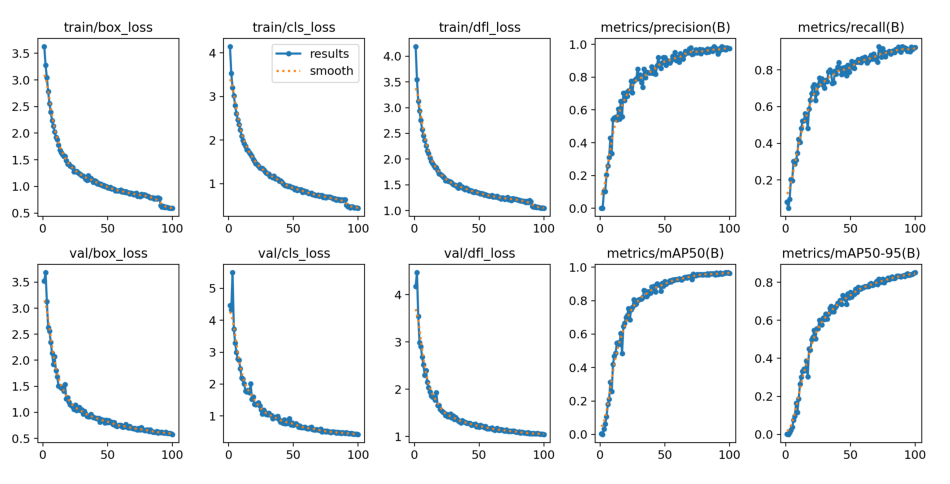

In [ ]:
#results of the model in each epoch
cm1 = cv2.imread('/content/runs/detect/train/results.png')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(cv2.cvtColor(cm1, cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

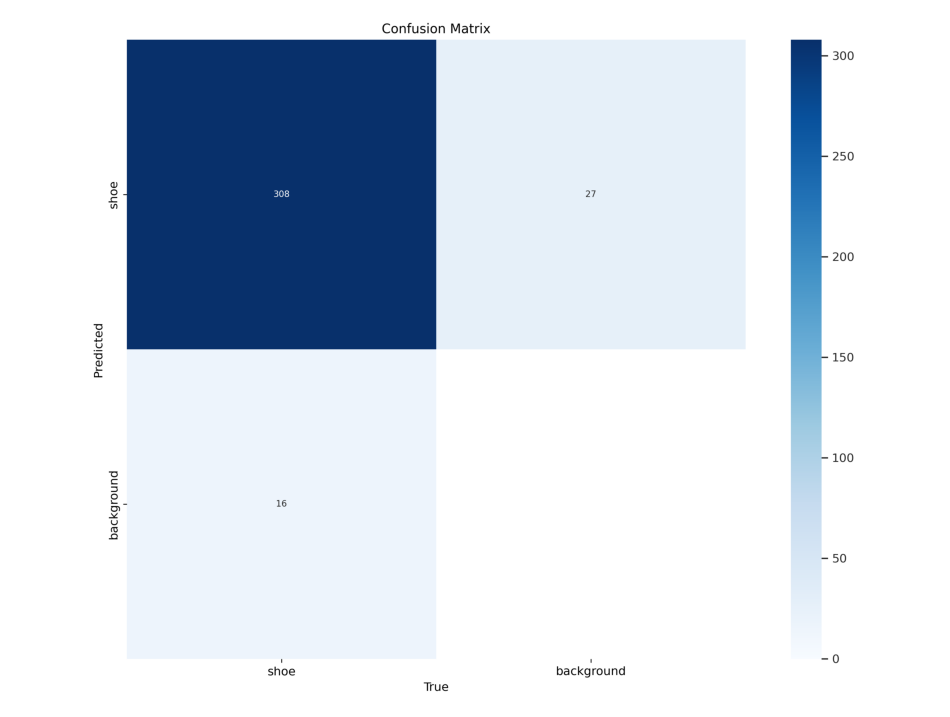

In [ ]:
#confusion matrix of the model
cm1 = cv2.imread('/content/runs/detect/train/confusion_matrix.png')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(cv2.cvtColor(cm1, cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

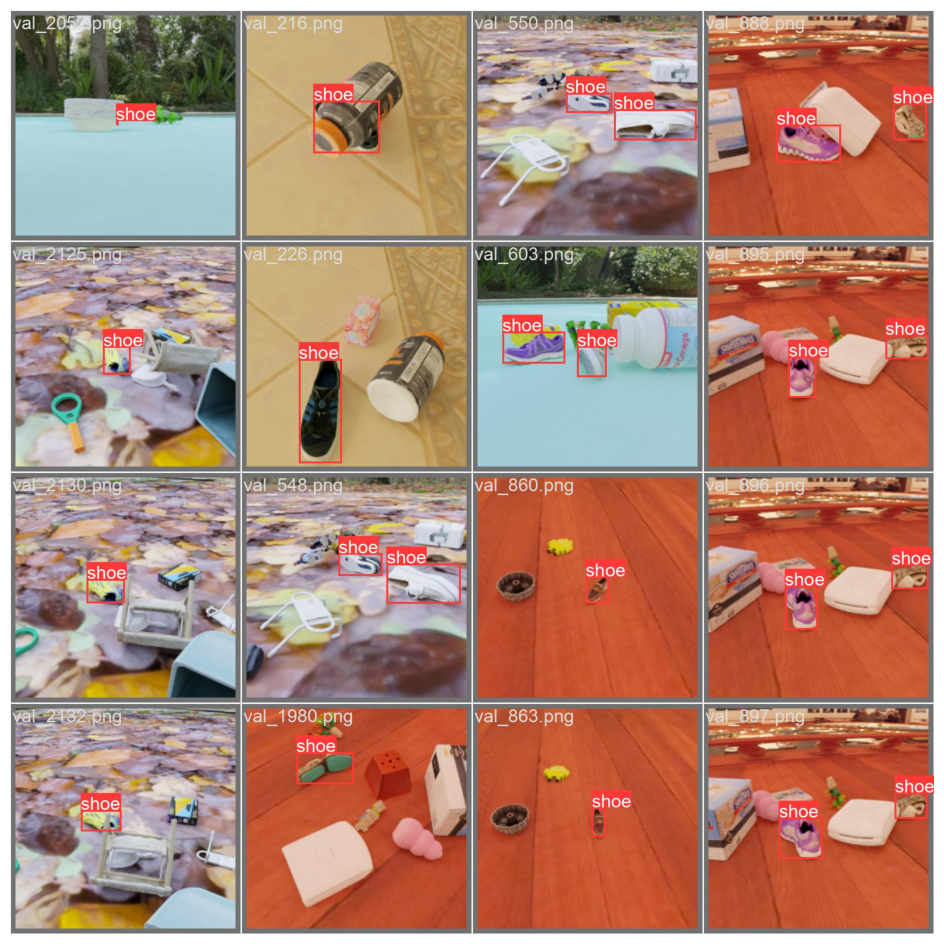

In [ ]:
#labels before the model
cm1 = cv2.imread('/content/runs/detect/train/val_batch1_labels.jpg')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(cv2.cvtColor(cm1, cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

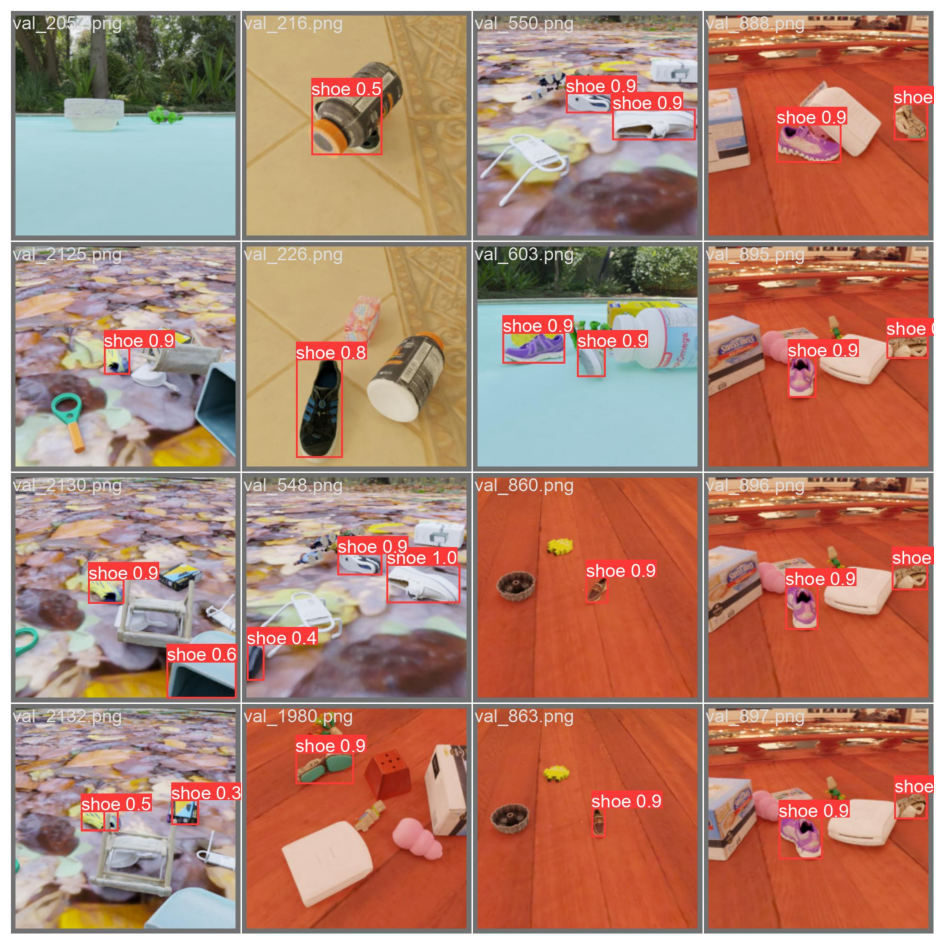

In [ ]:
#pred after the model
cm1 = cv2.imread('/content/runs/detect/train/val_batch1_pred.jpg')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(cv2.cvtColor(cm1, cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

# **Ablation Study**

In [ ]:
#train the ablation model
yolo_ablation = YOLO("/content/drive/MyDrive/cv_course/config0.yaml")
yolo_ablation.train(data="/content/drive/MyDrive/cv_course/data_yolo.yaml", epochs = 100)


                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   2655744  ultralytics.nn.modules.conv.Conv             [384

100%|██████████| 755k/755k [00:00<00:00, 105MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   2655744  ultralytics.nn.modules.conv.Conv             [384

100%|██████████| 6.23M/6.23M [00:00<00:00, 301MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/cv_course/Yolo_dataset/train/labels.cache... 765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 765/765 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/cv_course/Yolo_dataset/val/labels.cache... 164 images, 0 backgrounds, 0 corrupt: 100%|██████████| 164/164 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.06G      3.555      3.985      4.078         51        640: 100%|██████████| 48/48 [00:28<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]

                   all        164        324   0.000366     0.0556   0.000846   0.000214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.34G      2.986      3.377      3.433         35        640: 100%|██████████| 48/48 [00:23<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        164        324    0.00353      0.324     0.0028   0.000916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.36G      2.663      3.038      3.009         49        640: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        164        324      0.108     0.0895     0.0314     0.0111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.35G      2.566      2.832      2.902         43        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all        164        324     0.0877      0.142     0.0554     0.0176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.35G      2.328      2.607      2.721         45        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        164        324      0.319      0.262      0.184     0.0649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.36G      2.191      2.436      2.574         38        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        164        324      0.292      0.181      0.153      0.065



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.38G      2.069      2.263      2.451         40        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        164        324      0.399       0.38      0.302      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.37G      1.915      2.131      2.327         28        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        164        324      0.404      0.407      0.331      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.38G       1.86      2.062      2.266         35        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.388      0.404      0.361      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.39G       1.74       1.92      2.147         39        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.535      0.522      0.502      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.35G      1.701      1.836      2.113         36        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.506      0.474       0.46      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.37G      1.589      1.757      2.026         38        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        164        324      0.475      0.524      0.434      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.34G      1.536      1.687      1.955         51        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        164        324      0.489      0.546      0.511      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.36G      1.496      1.584      1.934         45        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        164        324      0.633      0.602      0.599      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.35G      1.442      1.581      1.896         39        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.693      0.614       0.65      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.36G      1.386      1.482      1.828         51        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.604      0.636      0.643      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.39G       1.35      1.464       1.79         41        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.681      0.679      0.694      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.34G      1.344      1.411      1.775         44        640: 100%|██████████| 48/48 [00:24<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.614      0.613      0.632      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.36G      1.271      1.368      1.742         42        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        164        324      0.673      0.682      0.707      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.37G      1.265      1.277      1.715         39        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.673      0.611      0.634      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.34G      1.225      1.273      1.676         39        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        164        324      0.714      0.667      0.728       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.35G      1.195      1.243      1.637         28        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.767      0.673      0.758      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.35G      1.153      1.211       1.62         32        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        164        324       0.68      0.689      0.726      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.36G       1.15      1.136      1.605         48        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.805      0.731      0.793       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.36G      1.129      1.138      1.581         33        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.776      0.731      0.803      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.36G      1.108      1.126      1.557         38        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.816      0.707      0.794      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.38G       1.11      1.137      1.571         44        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.746      0.701      0.757      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.36G      1.087      1.086      1.539         40        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.814      0.784       0.83      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.35G      1.043      1.061      1.512         35        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.848      0.713      0.848      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.36G      1.035      1.029       1.49         48        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        164        324      0.828      0.714      0.816      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.37G     0.9906          1      1.442         33        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324       0.78      0.824      0.847      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.37G      1.001     0.9543      1.442         45        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        164        324      0.804      0.796      0.855      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.37G     0.9712     0.9435      1.438         37        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.847      0.768      0.862      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.38G     0.9399     0.9175      1.424         30        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.827       0.78      0.856      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.37G     0.9952     0.9715      1.451         43        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.872      0.779       0.88      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.38G     0.9119     0.8835       1.38         36        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.852        0.8      0.884      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.36G      0.965     0.8974       1.42         40        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.902      0.769      0.886      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.36G     0.9272     0.8697      1.372         38        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        164        324      0.847      0.784      0.866      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.36G     0.8661     0.8064      1.332         37        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        164        324      0.904      0.812      0.908      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.35G     0.8941     0.8334       1.37         38        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.919      0.837      0.922      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.36G     0.8946     0.8033       1.35         43        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.913      0.821      0.918      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.36G     0.8648     0.7926      1.336         37        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.912      0.801      0.915      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.35G      0.861     0.7593      1.331         42        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.918      0.833      0.925      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.36G      0.845     0.7553      1.334         48        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.907      0.815      0.914      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.37G     0.8296      0.737      1.291         27        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.906      0.865      0.938      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.38G      0.821     0.7474      1.287         34        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.926      0.787      0.913       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.36G      0.848      0.753      1.307         38        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324       0.88      0.815      0.897      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.36G     0.8169     0.7158      1.277         29        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.916      0.879      0.936      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.35G     0.8103     0.7129      1.292         43        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        164        324      0.877      0.858      0.922      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.36G     0.8179     0.7381      1.292         43        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.943      0.815      0.932      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.36G     0.7865     0.6819      1.255         45        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        164        324      0.865      0.913      0.947      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.38G     0.7898     0.6971      1.258         46        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        164        324      0.937      0.895      0.948      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.37G     0.7661     0.6479      1.245         41        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.963      0.855       0.95      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.38G     0.7602     0.6589      1.235         32        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        164        324      0.955      0.851      0.946      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.36G     0.7464     0.6605      1.234         48        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.933      0.867      0.941      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.38G     0.7443     0.6612      1.225         39        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        164        324      0.926      0.864      0.944      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.36G      0.726     0.6287      1.217         53        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.932      0.888      0.948      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.36G     0.7167     0.6402      1.208         44        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.902      0.867      0.938      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.36G      0.735     0.6213      1.221         38        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.917      0.901      0.951      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.37G     0.7409       0.62      1.214         40        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.948      0.852      0.947      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.36G     0.7071     0.6023      1.205         25        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.963      0.895       0.96      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.36G     0.7067     0.5719      1.193         47        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.948      0.917      0.961      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.39G     0.6917     0.5874      1.185         34        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.963      0.886      0.957      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.34G     0.7065     0.6019      1.203         33        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324       0.96      0.891      0.957      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.34G     0.6899     0.5652      1.177         32        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.973      0.885      0.955      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.36G     0.6964      0.554      1.173         33        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        164        324      0.924      0.932       0.96      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.35G     0.6552     0.5498      1.146         45        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        164        324       0.98      0.907      0.971      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.36G     0.6778     0.5447      1.175         36        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        164        324      0.942      0.898      0.966       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.36G     0.6837     0.5626      1.191         33        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        164        324      0.935      0.923      0.962      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.36G     0.6564     0.5195      1.156         34        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        164        324      0.958      0.917      0.967      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.36G     0.6608     0.5306      1.157         43        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324       0.97      0.901       0.97      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.36G     0.6762     0.5547      1.172         32        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.987      0.904      0.969      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.35G     0.6355     0.5187      1.148         35        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        164        324      0.967      0.883       0.96      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.34G     0.6606     0.5308      1.163         25        640: 100%|██████████| 48/48 [00:23<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.965      0.925      0.971      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.36G     0.6327      0.501      1.132         26        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        164        324      0.965      0.923      0.974      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.34G     0.6665     0.5239       1.16         35        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324       0.98      0.888      0.966      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.39G     0.6374      0.528      1.152         31        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.974      0.923      0.971      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.38G     0.6433     0.5105       1.14         39        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.977      0.931      0.976      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.36G     0.6364     0.4963      1.136         38        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.971      0.922       0.97      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.36G     0.6138     0.4879      1.111         38        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        164        324      0.959      0.923      0.974      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.35G     0.6122     0.4716      1.116         38        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        164        324      0.995      0.914      0.978      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.36G     0.6145     0.4876      1.121         23        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        164        324      0.993      0.904      0.975      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.37G     0.5852     0.4579      1.103         39        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        164        324      0.974      0.928      0.978      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.36G     0.5841     0.4576      1.098         42        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.977      0.907      0.973      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.36G     0.5996       0.48      1.107         30        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        164        324       0.97      0.932      0.976       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.36G     0.5637     0.4313      1.073         43        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        164        324       0.98      0.924       0.97      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.37G     0.5952     0.4675      1.109         44        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]

                   all        164        324      0.963      0.932      0.975      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.36G     0.5669     0.4475      1.079         43        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        164        324      0.984      0.936      0.981      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.39G     0.5794     0.4612      1.112         47        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.981       0.92      0.975      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.36G      0.573     0.4538      1.098         34        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324       0.98      0.924      0.977       0.88


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.36G     0.4551     0.3668      1.018         20        640: 100%|██████████| 48/48 [00:24<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.974      0.929      0.976      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.35G     0.4423     0.3377      1.011         20        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324       0.98      0.921      0.975      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.36G     0.4432     0.3377      1.009         24        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.971      0.935      0.975      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      7.35G     0.4256     0.3168      0.988         21        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        164        324      0.984      0.923       0.98        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.36G     0.4363     0.3369     0.9932         19        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        164        324       0.99      0.925       0.98      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.34G     0.4306     0.3323     0.9994         28        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.971      0.954       0.98        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.36G     0.4159     0.3191     0.9844         22        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

                   all        164        324      0.986      0.944      0.982      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.36G     0.4162     0.3136     0.9781         27        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]

                   all        164        324      0.984      0.946      0.981      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.36G      0.407     0.3099     0.9827         27        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.966      0.951      0.982      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.36G     0.4077     0.3044     0.9733         26        640: 100%|██████████| 48/48 [00:23<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        164        324      0.992      0.929      0.982      0.908



100 epochs completed in 0.781 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 68.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 68.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
config0 summary (fused): 218 layers, 33934003 parameters, 0 gradients, 85.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]


                   all        164        324      0.992      0.929      0.982      0.907
Speed: 0.2ms preprocess, 10.2ms inference, 0.0ms loss, 7.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f2674739480>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
#results of the last 5 epochs
print("Results of each epoch in training for model YOLOv8")
results = pd.read_csv('/content/runs/detect/train2/results.csv')
results.tail()

Results of each epoch in training for model YOLOv8


epoch           train/box_loss           train/cls_loss  \
95                       96                  0.43058                  0.33232   
96                       97                  0.41587                  0.31908   
97                       98                  0.41618                  0.31361   
98                       99                  0.40703                  0.30992   
99                      100                  0.40772                  0.30437   

             train/dfl_loss     metrics/precision(B)        metrics/recall(B)  \
95                  0.99943                  0.97051                  0.95370   
96                  0.98440                  0.98634                  0.94444   
97                  0.97812                  0.98396                  0.94646   
98                  0.98271                  0.96554                  0.95135   
99                  0.97332                  0.99235                  0.92901   

           metrics/mAP50(B)      metrics/mAP50-95(B)             val/box_loss  \
95                  0.98049                  0.90047                  0.44322   
96                  0.98230                  0.90621                  0.44331   
97                  0.98129                  0.90262                  0.44453   
98                  0.98151                  0.90743                  0.43295   
99                  0.98174                  0.90774                  0.42864   

               val/cls_loss             val/dfl_loss                   lr/pg0  \
95                  0.30450                  1.01350                 0.000139   
96                  0.29826                  1.00310                 0.000119   
97                  0.29821                  1.00030                 0.000099   
98                  0.29278                  0.99332                 0.000079   
99                  0.28967                  0.98743                 0.000060   

                     lr/pg1                   lr/pg2  
95                 0.000139                 0.000139  
96                 0.000119                 0.000119  
97                 0.000099                 0.000099  
98                 0.000079                 0.000079  
99                 0.000060                 0.000060

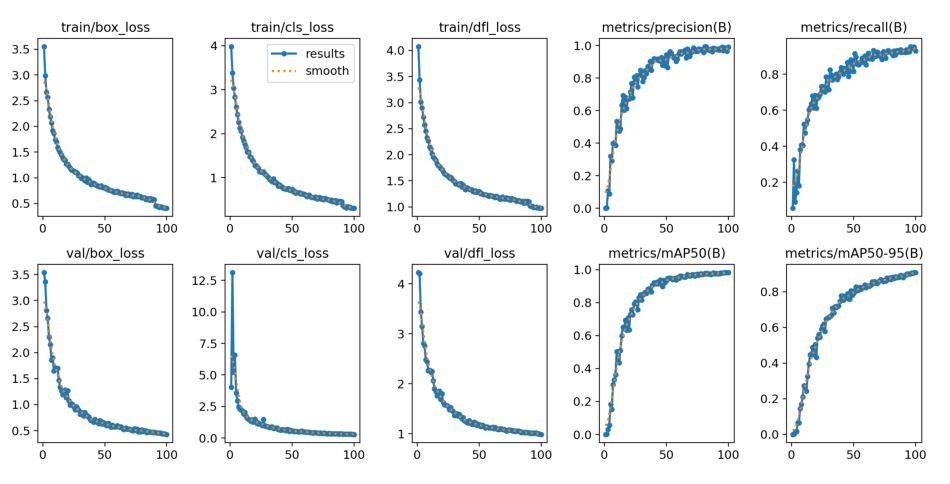

In [ ]:
#results of the model in each epoch
cm1 = cv2.imread('/content/runs/detect/train2/results.png')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(cv2.cvtColor(cm1, cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

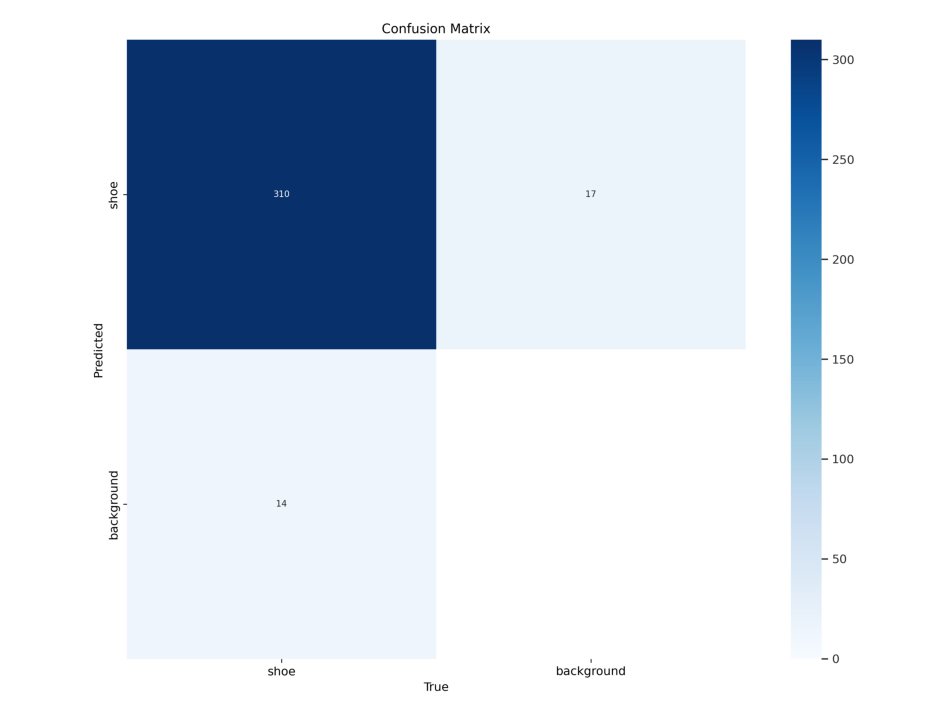

In [ ]:
#confusion matrix of the model
cm1 = cv2.imread('/content/runs/detect/train2/confusion_matrix.png')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(cv2.cvtColor(cm1, cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

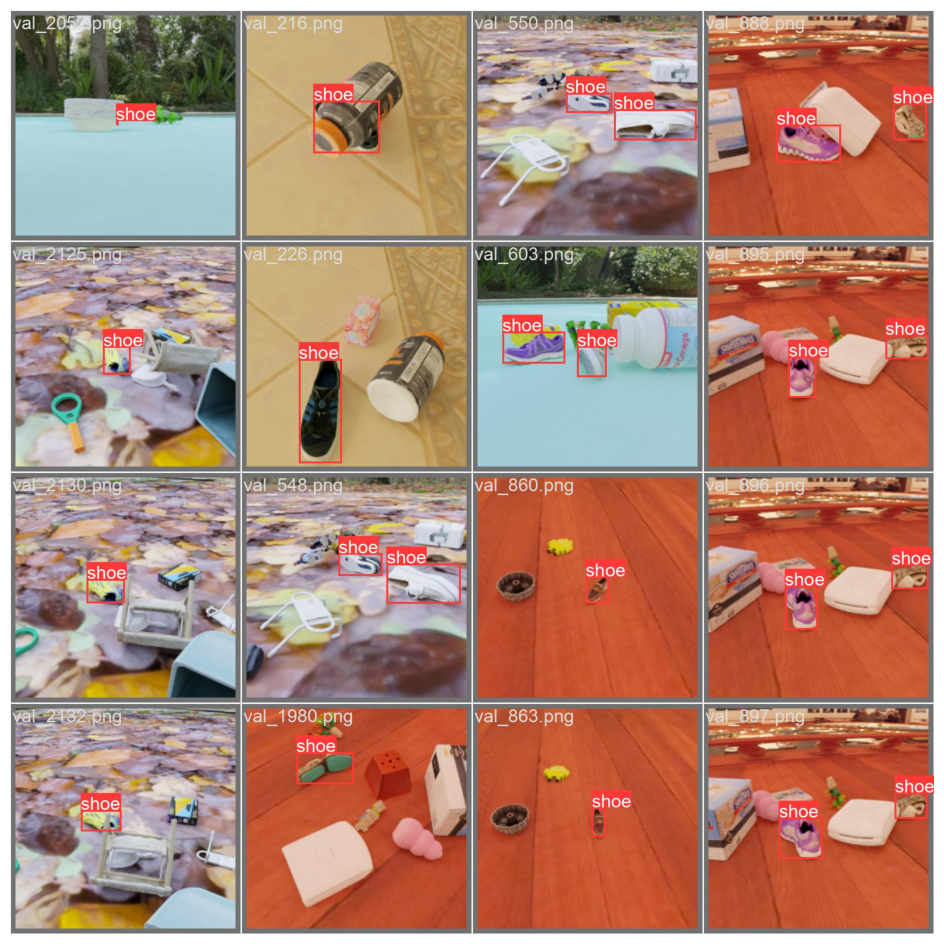

In [ ]:
#labels before the model
cm1 = cv2.imread('/content/runs/detect/train2/val_batch1_labels.jpg')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(cv2.cvtColor(cm1, cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

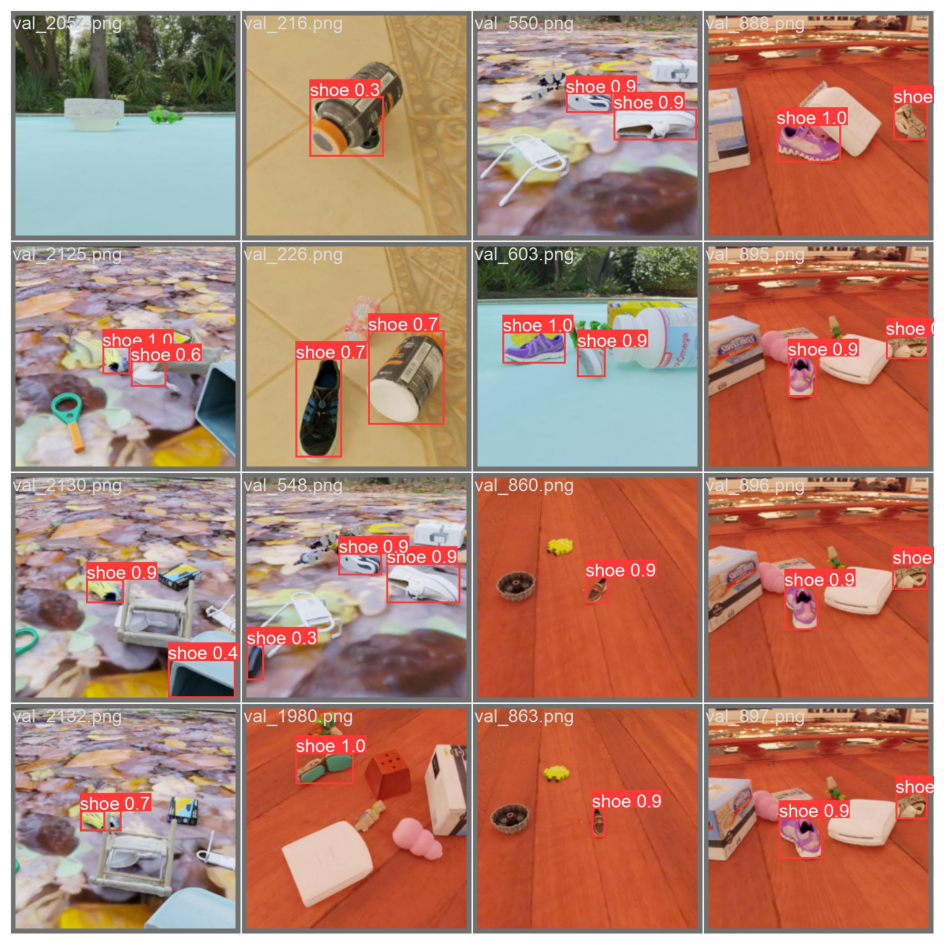

In [ ]:
#pred after the model
cm1 = cv2.imread('/content/runs/detect/train2/val_batch1_pred.jpg')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(cv2.cvtColor(cm1, cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

In [ ]:
#save the run folder
import shutil
shutil.copytree('/content/runs', '/content/drive/MyDrive/cv_course/runs')

'/content/drive/MyDrive/cv_course/runs'